# LSTM on GeorgeMcIntire Fake or Real News Dataset

This notebook runs a bags of words model (CountVectorizer), as well as an LSTM on the George Mc dataset. The goal is to establish that our LSTM is working properly.

In [10]:
# General libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import datetime
import random

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn import mixture
from sklearn.model_selection import train_test_split

# SK-learn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, auc

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [2]:
fr = pd.read_csv("../data/fakerealnews_GeorgeMcIntire/fake_or_real_news.csv")
fr.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## Model: Bag of Words - Using text only

Bag of words with linear regression gives us 94% accuracy!

In [3]:
# Split into train and test
x_train, x_test, y_train, y_test = train_test_split(fr['text'],np.where(fr['label']=='FAKE', 1, 0), 
                                                    test_size = .2, random_state = 1)

In [4]:
vectorizer = CountVectorizer()
train_data = vectorizer.fit_transform(x_train)
test_data = vectorizer.transform(x_test)

print("Size of the vocabulary:", train_data.shape[1])

Size of the vocabulary: 61502


In [5]:
# Logisitc modeling

log_clf = LogisticRegression()
C = {"C": [0.00001, 0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(train_data, y_train)

log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data, y_train)
log_clf_best_predicted = log_clf_best.predict(test_data)
fpr, tpr, _ = metrics.roc_curve(y_test, log_clf_best_predicted)
roc_auc = auc(fpr, tpr)

print('----- Logistic Regression -----')
print (log_gs.best_params_)
print ("Logistic accuracy: {:2.5f}%".format(accuracy_score(log_clf_best_predicted, y_test) * 100))
print ("Logistic accuracy (AUC): {:2.5f}%".format(metrics.auc(fpr,tpr) * 100))

# print confusion matrix to identify mistakes
print('--- Confusion Matrix ---')
print (confusion_matrix(y_test, log_clf_best_predicted))
print('-----------------------------------')

----- Logistic Regression -----
{'C': 0.04}
Logistic accuracy: 94.31728%
Logistic accuracy (AUC): 94.29985%
--- Confusion Matrix ---
[[618  33]
 [ 39 577]]
-----------------------------------


## Model: Bag of Words - Using title and text

Performance is the same using title and text. This shows that adding the title doesn't hurt the model.

In [6]:
fr['title_and_text'] = fr['title'] + ' ' + fr['text']

In [7]:
# Split into train and test
x_train, x_test, y_train, y_test = train_test_split(fr['title_and_text'],np.where(fr['label']=='FAKE', 1, 0), 
                                                    test_size = .2, random_state = 1)

In [8]:
vectorizer = CountVectorizer()
train_data = vectorizer.fit_transform(x_train)
test_data = vectorizer.transform(x_test)

print("Size of the vocabulary:", train_data.shape[1])

Size of the vocabulary: 61750


In [9]:
# Logisitc modeling

log_clf = LogisticRegression()
C = {"C": [0.00001, 0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(train_data, y_train)

log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data, y_train)
log_clf_best_predicted = log_clf_best.predict(test_data)
fpr, tpr, _ = metrics.roc_curve(y_test, log_clf_best_predicted)
roc_auc = auc(fpr, tpr)

print('----- Logistic Regression -----')
print (log_gs.best_params_)
print ("Logistic accuracy: {:2.5f}%".format(accuracy_score(log_clf_best_predicted, y_test) * 100))
print ("Logistic accuracy (AUC): {:2.5f}%".format(metrics.auc(fpr,tpr) * 100))

# print confusion matrix to identify mistakes
print('--- Confusion Matrix ---')
print (confusion_matrix(y_test, log_clf_best_predicted))
print('-----------------------------------')

----- Logistic Regression -----
{'C': 0.05}
Logistic accuracy: 94.31728%
Logistic accuracy (AUC): 94.32604%
--- Confusion Matrix ---
[[612  39]
 [ 33 583]]
-----------------------------------


## Model: LSTM

(array([4.055e+03, 1.757e+03, 3.260e+02, 9.200e+01, 4.500e+01, 3.100e+01,
        9.000e+00, 5.000e+00, 6.000e+00, 4.000e+00]),
 array([3.0000e+00, 8.2070e+02, 1.6384e+03, 2.4561e+03, 3.2738e+03,
        4.0915e+03, 4.9092e+03, 5.7269e+03, 6.5446e+03, 7.3623e+03,
        8.1800e+03]),
 <a list of 10 Patch objects>)

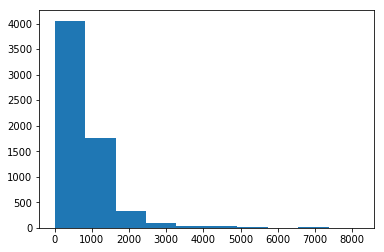

In [24]:
# See how long a typical new article is, in order to choose max sequence length
words = fr['title_and_text'].str.lower().str.split()
fr['num_words'] = words.apply(len)
# fr['title_and_text'].iloc[0]
# plt.hist(fr['num_words'], bins=20)
plt.hist(fr[fr['num_words'] < 10000]['num_words'])

### Load GloVe

In [25]:
# Supply location of GloVe text file, location of data, and max word length of news article
glove_filepath = '../models/embeddings/glove.6B.50d.txt'
maxSeqLength = 1000 # Lets start with 1000
numDimensions = 50  # Of embeddings

In [26]:
# Function to load GloVe embedding data, and convert it to three useful formats
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    wordsList = []
    embeddings = []
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        wordsList.append(word)
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
        embeddings.append(embedding)
    print ("Done.",len(model)," words loaded!")
    f.close()
    return wordsList, embeddings, model

In [27]:
wordsList, embeddings, model = loadGloveModel(glove_filepath)

Loading Glove Model
Done. 400000  words loaded!


### Embed News Articles

In [28]:
# Function that removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
def cleanArticle(string):
    strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

# Function that takes a news article as an input.
# It generates a fixed sequences of integers corresponding to the index of the embedding in the embedding lookup
# It caps the number of embedded words (i.e. article length) at maxSeqLength
# Words that do not exist in GloVe, will be assigned to a random embedding. In this case, the one at position 39999
def getArticleMatrix(article):
    articleMatrix = np.zeros(maxSeqLength, dtype='int32')
    cleanedArticle = cleanArticle(article)
    split = cleanedArticle.split()
    for indexCounter,word in enumerate(split):
        if indexCounter==maxSeqLength:
            break
        try:
            articleMatrix[indexCounter] = wordsList.index(word)
        except ValueError:
            articleMatrix[indexCounter] = 399999 #Vector for unkown words
    return articleMatrix

In [31]:
# Embed the articles ** Heads up, This takes a little over 20 minutes!! (4 vCPUs, 15 GB memory)
fr['news_embed'] = fr['title_and_text'].apply(getArticleMatrix)

In [32]:
fr.head()

,Unnamed: 0,title,text,label,title_and_text,num_words,news_embed
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...,1301,"[81, 86, 9332, 291289, 1655, 2588, 25007, 7, 3..."
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,460,"[1716, 0, 5159, 1600, 923, 3512, 1805, 209, 15..."
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy U....,440,"[2932, 4, 242, 4, 1035, 6, 7536, 3, 7823, 95, ..."
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,Bernie supporters on Twitter erupt in anger ag...,419,"[13574, 1453, 13, 10360, 20454, 6, 3946, 98, 0..."
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,The Battle of New York: Why This Primary Matte...,326,"[0, 903, 3, 50, 196, 738, 37, 1417, 3072, 47, ..."


### Train LSTM Model

In [33]:
import tensorflow as tf

/home/miketp333/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [34]:
# Indicate news df to use
news_df = fr

# Embedded word vector lookup. Convert from list to numpy array
wordVectors = np.asarray(embeddings)

# Split news articles and classification into test and train sets
newsVectors, newsVectors_test, classVector, classVector_test = \
    train_test_split(news_df['news_embed'],
                     np.where(fr['label']=='FAKE', 1, 0),
                     test_size = .2,
                     random_state = 1)

newsVectors, newsVectors_test, classVector, classVector_test = \
    np.asarray(newsVectors), \
    np.asarray(newsVectors_test), \
    np.asarray(classVector), \
    np.asarray(classVector_test)

In [35]:
def getTrainBatch(ids, label):
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    # Get indexes of real and fake news and shuffle them
    real = list(np.where(label==0)[0])
    fake = list(np.where(label==1)[0])
    random.shuffle(real)
    random.shuffle(fake)
    
    # Number to pull for each of thet two classifications
    num = int(batchSize/2)
    
    # If batch size an even number. Split evenly fake and real
    if (batchSize % 2 == 0):
        comb = real[0:num] + fake[0:num]
        # Repeat the labels
        labels = [[0,1]] * num + [[1,0]] * num
    # If batch size an odd number. Split evenly fake and real, and add 1 fake
    else:
        comb = real[0:num] + fake[0:num]
        comb = comb + fake[num:num+1]
        labels = [[0,1]] * num + [[1,0]] * num
        labels = labels +  [[1,0]]
    
    for i in range(len(comb)):
        arr[i] = ids[comb[i]]
          
    return arr, np.asarray(labels)


# Use all test data. Make sure batch size = length(test data) because I did not make batch size dynamic
def getTestBatch(ids, label):
    labels = []
    num_test = len(label)
    arr = np.zeros([num_test, maxSeqLength])
    for i in range(num_test):
        arr[i] = ids[i]
        if label[i] == 0:
            labels.append([0,1])
        else:
            labels.append([1,0])
            
    return arr, np.asarray(labels) 

In [80]:
# Hyperparameters - 3 min (4 vCPUs, 15 GB memory)
batchSize = len(classVector_test)
numClasses = 2
# number_of_layers = 2
lstmUnits = 100
iterations = 1000
learning_rate = 0.01

In [81]:
tf.reset_default_graph()
tf.set_random_seed(42)
 
labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

In [82]:
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

In [83]:
# ### single layer

lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits, forget_bias=0.0)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)  # Add dropout or not?
value, final_h_ = tf.nn.dynamic_rnn(lstmCell, tf.cast(data,tf.float32), dtype=tf.float32)


# ### multiple layers

# def lstm_cell():
#     return tf.contrib.rnn.BasicLSTMCell(lstmUnits)

# stacked_lstm = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(number_of_layers)])
# initial_h = stacked_lstm.zero_state(batchSize, tf.float32)
# value, final_h = tf.nn.dynamic_rnn(stacked_lstm, tf.cast(data,tf.float32), initial_state=initial_h, dtype=tf.float32) 

In [84]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.0, shape=[numClasses]))
# Transpose rows and columns (0-->1, 1-->0, 2-->2)
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

In [85]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

In [86]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=prediction)) 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

/home/miketp333/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 126700000 elements. This may consume a large amount of memory.
  num_elements)


In [87]:

sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

# Set up Tensorboard
tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

print(datetime.datetime.now())

# Train model
for i in range(iterations):
            
    nextBatch, nextBatchLabels = getTrainBatch(newsVectors, classVector)
    
#     if i == 0:
#         h = sess.run(initial_h, {input_data: nextBatch})
        
    # Write summary to Tensorboard
    if (i % 50 == 0):
        summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
        writer.add_summary(summary, i)

    #Save the network every 10,000 training iterations, or on last iteration
    if ((i % 10000 == 0 and i != 0) or i == iterations - 1):
        save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
        print("saved to %s" % save_path)
writer.close()
print(datetime.datetime.now())

2018-11-16 03:46:12.267475
saved to models/pretrained_lstm.ckpt-999
2018-11-16 03:49:20.196415


In [88]:
sess.close()

### Test LSTM Model

In [89]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('models'))

INFO:tensorflow:Restoring parameters from models/pretrained_lstm.ckpt-999


In [90]:
# View results on test data
nextBatch, nextBatchLabels = getTestBatch(newsVectors_test, classVector_test)
print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)
predictions = sess.run(prediction, {input_data: nextBatch})
predictions = [p[0] > p[1] for p in predictions]
classVector_test
print(confusion_matrix(classVector_test, predictions))
print("Accuracy:", sum(classVector_test==predictions) / len(predictions))

Accuracy for this batch: 45.93527913093567
[[526  90]
 [580  71]]
Accuracy: 0.4711917916337806


In [91]:
sess.close()